In [2]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [3]:
hotels=pd.read_csv("C:/Users/abdel/ACL/archive/hotels.csv")
reviews=pd.read_csv("C:/Users/abdel/ACL/archive/reviews.csv")
users=pd.read_csv("C:/Users/abdel/ACL/archive/users.csv")
hotels = hotels.rename(columns={'country': 'hotel_country'})
users = users.rename(columns={'country': 'user_country'})

In [4]:
review_hotel_df=reviews.merge(hotels,on='hotel_id',how='left')
df=review_hotel_df.merge(users,on='user_id',how='left')

In [5]:
print(f"Total rows in df (should be ~50,000): {len(df)}")
print("\nNull values *after* merge:")
print(df[['user_gender', 'age_group', 'traveller_type']].isnull().sum())

Total rows in df (should be ~50,000): 50000

Null values *after* merge:
user_gender       0
age_group         0
traveller_type    0
dtype: int64


In [6]:
groups={'North_America':['United States','Canada'],
        'Western_Europe':['Germany','France','United Kingdom','Netherlands','Spain','Italy'],
        'Eastern_Europe':['Russia'],
        'East_Asia':['China','Japan','South Korea'],
        'Southeast_Asia':['Thailand','Singapore'],
        'Middle_East':['United Arab Emirates','Turkey'],
        'Africa':['Egypt','Nigeria','South Africa'],
        'Oceania':['Australia','New Zealand'],
        'South_America':['Brazil','Argentina'],
        'South_Asia':['India'],
        'North_America_Mexico':['Mexico']}

df["country_group"]=df["hotel_country"].apply(lambda x: next((key for key, value in groups.items() if x in value), "Other"))

df[["hotel_country","user_country","country_group"]]

,hotel_country,user_country,country_group
0,United States,New Zealand,North_America
1,Japan,United Kingdom,East_Asia
2,Egypt,Spain,Africa
3,Spain,United Kingdom,Western_Europe
4,Russia,Australia,Eastern_Europe
...,...,...,...
49995,Nigeria,Mexico,Africa
49996,Brazil,New Zealand,South_America
49997,Singapore,Russia,Southeast_Asia
49998,Turkey,United Kingdom,Middle_East


In [7]:
df = pd.get_dummies(df, columns=['traveller_type'], drop_first=True)
df = pd.get_dummies(df, columns=['user_country'], drop_first=True)
df = pd.get_dummies(df, columns=['user_gender'], drop_first=True)

age_order = {
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55+': 5
}

df['age'] = df['age_group'].map(age_order)
df.drop(columns=['age_group'], inplace=True)

In [8]:

df['diff_cleanliness'] = df['score_cleanliness'] - df['cleanliness_base']
df['diff_comfort'] = df['score_comfort'] - df['comfort_base']
df['diff_facilities'] = df['score_facilities'] - df['facilities_base']
df['diff_overall_vs_star'] = df['score_overall'] - df['star_rating']
df['diff_location'] = df['score_location'] - df['location_base']
df['diff_staff'] = df['score_staff'] - df['staff_base']
df['diff_value_for_money'] = df['score_value_for_money'] - df['value_for_money_base']

print("Successfully created all 'diff' features. ✅")
print("\nHead of the new 'diff' features:")
print(df[[ 'diff_cleanliness', 'diff_comfort', 'diff_facilities','diff_overall_vs_star', 'diff_location', 'diff_staff', 'diff_value_for_money']].head())

Successfully created all 'diff' features. ✅

Head of the new 'diff' features:
   diff_cleanliness  diff_comfort  diff_facilities  diff_overall_vs_star  \
0              -0.5          -0.1             -0.4                   3.7   
1               0.4           0.1             -0.3                   4.1   
2               0.9           0.1             -0.3                   3.8   
3              -0.2          -0.3             -0.4                   3.9   
4              -0.2           0.2              0.3                   4.1   

   diff_location  diff_staff  diff_value_for_money  
0           -0.5         0.2                   0.7  
1            0.1        -0.1                   0.4  
2           -0.4        -0.6                   0.2  
3           -0.1         0.1                  -0.5  
4           -0.7         0.3                   0.3  


In [9]:
X = df[[
    'score_overall',
    'score_cleanliness',
    'score_comfort',
    'score_facilities',
    'score_location',
    'score_staff',
    'score_value_for_money',
    'cleanliness_base',
    'comfort_base',
    'facilities_base',
    'location_base',
    'staff_base',
    'value_for_money_base',
    'star_rating',
    'traveller_type_Couple',
    'traveller_type_Family',
    'traveller_type_Solo',
    'user_gender_Male',
    'user_gender_Other',
    'age'
]]
y = df['country_group']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
log_model = LogisticRegression(
    max_iter=100,
)

In [12]:
log_model.fit(X_train,y_train)

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [13]:
y_pred = log_model.predict(X_test)

print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))

=== Logistic Regression Evaluation ===
Accuracy: 0.5267
Precision: 0.4837016629086009
Recall: 0.5267
F1 Score: 0.4948057309061611

Detailed Report:
                       precision    recall  f1-score   support

              Africa       0.43      0.53      0.48      1247
           East_Asia       0.38      0.44      0.41      1195
      Eastern_Europe       0.37      0.35      0.36       358
         Middle_East       0.57      0.51      0.54       816
       North_America       0.70      0.47      0.56       776
North_America_Mexico       0.57      0.25      0.35       400
             Oceania       0.07      0.02      0.03       805
       South_America       0.51      0.61      0.55       813
          South_Asia       0.00      0.00      0.00       389
      Southeast_Asia       0.72      0.81      0.76       818
      Western_Europe       0.60      0.80      0.68      2383

            accuracy                           0.53     10000
           macro avg       0.45      0.43  

In [14]:
# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode for NN output layer
y_categorical = to_categorical(y_encoded)

In [15]:
print("y_encoded shape:", y_encoded.shape)
print("y_categorical shape:", y_categorical.shape)

y_encoded shape: (50000,)
y_categorical shape: (50000, 11)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  
])

c:\Users\abdel\fire_env_tf\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (40000, 20)
y_train shape: (40000, 11)
X_train_scaled shape: (40000, 20)
y_train shape: (40000, 11)


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    epochs=50, batch_size=32,
                    validation_split=0.2, verbose=1)

y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("=== Neural Network Evaluation ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7085 - loss: 0.8488 - val_accuracy: 0.9931 - val_loss: 0.1044
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0907 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9974 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9988 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 5.6303e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9993 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 1.9611e-04
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9996 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 9.3922e-05
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 7.9683e-05
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9995 -

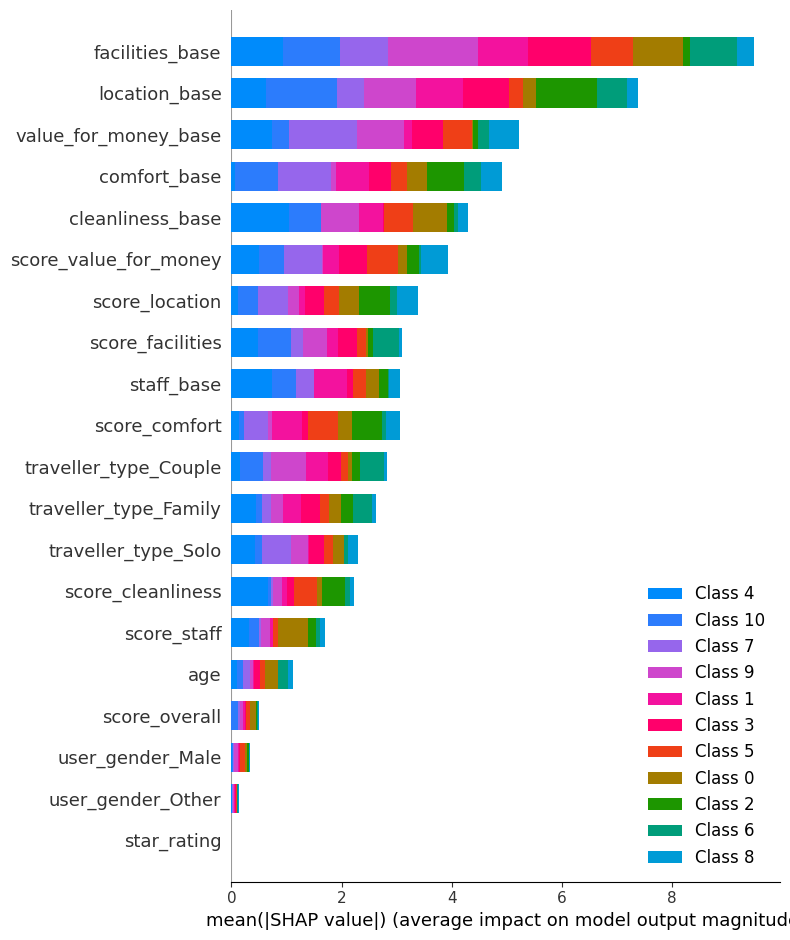

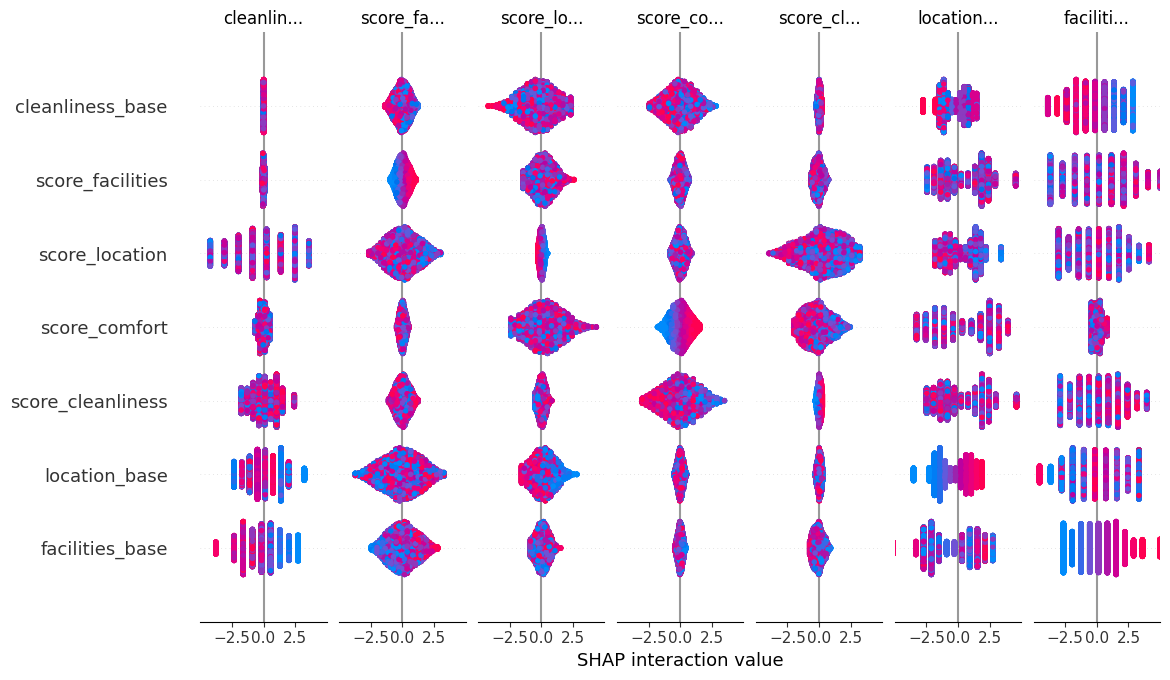

In [21]:
# global explanation
explainer = shap.LinearExplainer(log_model, X_train)

shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]


shap_values = np.array(shap_values, dtype=np.float64)


shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=X_test.shape[1], show=True)
shap.summary_plot(shap_values, X_test)